# Binary Variational Autoencoder

Ideia baseada no artigo: [Binary Autoencoder for Text Modeling](https://link.springer.com/chapter/10.1007/978-3-030-34518-1_10)

In [1]:
# libs
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt

---
* Utilities

In [2]:
architecture_name = "binary_vae"
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

workers = 8
batch_size = 32    
train_dataset = datasets.ImageFolder(root="/home/ninja/MNIST/training/",
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                  transforms.Grayscale(num_output_channels=1),]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

test_dataset = datasets.ImageFolder(root="/home/ninja/MNIST/testing/",
                                    transform=transforms.Compose([transforms.ToTensor(),
                                                                 transforms.Grayscale(num_output_channels=1),]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [3]:
def generate_samples(encoder,decoder,mb_size,loader=train_loader):
    for _, batch in enumerate(loader):
        X = Variable(batch[0].view(-1,784)).to(device)
        X_size = X.shape[0]
        probs = encoder(X)
        z = sample_z(probs,X_size)
        X_sample = decoder(z)
    return X_sample[:mb_size]
    
def show_img(title,img):
    print(title)
    npimg = np.transpose(make_grid(img).numpy(),(1,2,0))
    plt.imshow(npimg)
    
def generate_full_sample(loader=train_loader):
    X_fake_samples = torch.Tensor().to(device)
    X_real_samples = torch.Tensor().to(device)
    Z_samples = torch.Tensor().to(device)
    y_samples = torch.Tensor().to(device)
    for step, batch in enumerate(loader):
        X = Variable(batch[0].view(-1,784)).to(device)
        y = Variable(batch[1]).to(device)
        probs = encoder(X)
        z = sample_z(probs,X.shape[0])
        X_fake_samples = torch.cat([X_fake_samples,decoder(z)],dim=0)
        X_real_samples = torch.cat([X_real_samples,X],dim=0)
        Z_samples = torch.cat([Z_samples,z],dim=0)
        y_samples = torch.cat([y_samples,y],dim=0)
        if step >= 100: break
    return X_fake_samples,X_real_samples,Z_samples,y_samples

---

In [4]:
mb_size = batch_size
Z_dim = 32
X_dim = 784
y_dim = 1
a_dim, b_dim, c_dim, h_dim = [784,392,196,98]
lr = 1e-3

class STEFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        values = torch.tensor([0.5]).to(device)
        return torch.heaviside(input,values)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.clamp_(-1, 1)

class Encoder(torch.nn.Module):
    def __init__(self,ngpu):
        super(Encoder,self).__init__()
        self.ngpu = ngpu
        self.hidden1 = torch.nn.Linear(X_dim, a_dim)
        self.hidden2 = torch.nn.Linear(a_dim, b_dim)
        self.hidden3 = torch.nn.Linear(b_dim, c_dim)
        self.hidden4 = torch.nn.Linear(c_dim, h_dim)
        self.hidden5 = torch.nn.Linear(h_dim, Z_dim)
    
    def forward(self,X):
        h = F.relu(self.hidden1(X))
        h = F.relu(self.hidden2(h))
        h = F.relu(self.hidden3(h))
        h = F.relu(self.hidden4(h))
        out = torch.sigmoid(self.hidden5(h))
        return out

def sample_z(probs,mb_size):
    
    xi = Variable(torch.rand(mb_size, Z_dim)).to(device)
    step = STEFunction.apply
    z = step(probs - xi)
    return z

class Decoder(torch.nn.Module):
    def __init__(self,ngpu):
        super(Decoder,self).__init__()
        self.ngpu = ngpu
        self.hidden1 = torch.nn.Linear(Z_dim, h_dim)
        self.hidden2 = torch.nn.Linear(h_dim, c_dim)
        self.hidden3 = torch.nn.Linear(c_dim, b_dim)
        self.hidden4 = torch.nn.Linear(b_dim, a_dim)
        self.hidden5 = torch.nn.Linear(a_dim, X_dim)
    
    def forward(self,z):
        h = F.relu(self.hidden1(z))
        h = F.relu(self.hidden2(h))
        h = F.relu(self.hidden3(h))
        h = F.relu(self.hidden4(h))
        out = torch.sigmoid(self.hidden5(h))
        return out
    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight).to(device)
        m.bias.data.fill_(0.001)
    
encoder = Encoder(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    encoder = nn.DataParallel(encoder, list(range(ngpu)))
decoder = Decoder(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    decoder = nn.DataParallel(decoder, list(range(ngpu)))

params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params, lr=lr, betas=(0.9,0.999))

#Inicializar pesos das redes
encoder.apply(init_weights)
decoder.apply(init_weights)

# lists to plot loss history
loss_his = []

#load saved networks
# encoder.load_state_dict(torch.load(f'models/{architecture_name}_encoder_mnist.pt'))
# decoder.load_state_dict(torch.load(f'models/{architecture_name}_decoder_mnist.pt'))
print(encoder)
print(decoder)

Encoder(
  (hidden1): Linear(in_features=784, out_features=784, bias=True)
  (hidden2): Linear(in_features=784, out_features=392, bias=True)
  (hidden3): Linear(in_features=392, out_features=196, bias=True)
  (hidden4): Linear(in_features=196, out_features=98, bias=True)
  (hidden5): Linear(in_features=98, out_features=32, bias=True)
)
Decoder(
  (hidden1): Linear(in_features=32, out_features=98, bias=True)
  (hidden2): Linear(in_features=98, out_features=196, bias=True)
  (hidden3): Linear(in_features=196, out_features=392, bias=True)
  (hidden4): Linear(in_features=392, out_features=784, bias=True)
  (hidden5): Linear(in_features=784, out_features=784, bias=True)
)


In [ ]:
%%time
epochs = 50

for epoch in range(1,epochs+1):
    for step, batch_x in enumerate(train_loader):
        X = Variable(batch_x[0].view(-1,784)).to(device)
        X_size = X.shape[0]
        probs = encoder(X)
        z = sample_z(probs,X_size)
        X_sample = decoder(z)
        recon_loss = F.binary_cross_entropy(X_sample, X, reduction='sum')
        loss = recon_loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_his.append(loss.data)
    if epoch % 2 == 0:
        print(f'Epoch-{epoch}| Average loss: {loss.mean().data:.5f}')

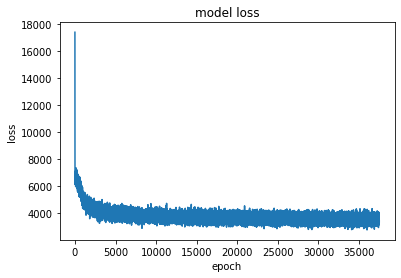

In [9]:
plt.plot(loss_his)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show();

In [10]:
# Save model
torch.save(encoder.state_dict(), f'models/{architecture_name}_encoder_mnist.pt')
torch.save(decoder.state_dict(), f'models/{architecture_name}_decoder_mnist.pt')

### Evaluate images and embeddings

train fake


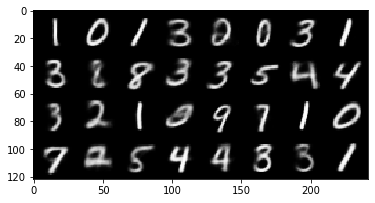

In [63]:
X_fake_samples,X_real_samples,Z_samples,y_samples = generate_full_sample()
show_img("train fake",X_fake_samples[:32].cpu().view(32,1,28,28))

train real


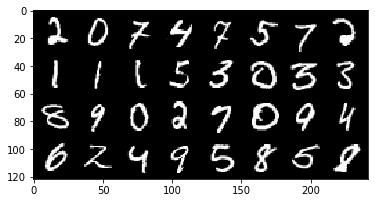

In [62]:
show_img("train real",X_real_samples[:32].cpu().view(32,1,28,28))

In [11]:
sample_size = 1000
X_fake_samples,X_real_samples,Z_samples,y_samples = generate_full_sample(test_loader)
X_fake = X_fake_samples[:sample_size].cpu().data.numpy()
X_real = X_real_samples[:sample_size].cpu().data.numpy()
Z = Z_samples[:sample_size].cpu().data.numpy()
y_labels = y_samples[:sample_size].cpu().data.numpy()

test fake


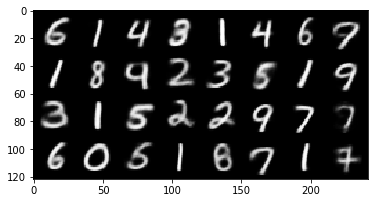

In [12]:
show_img("test fake",X_fake_samples[:32].cpu().view(32,1,28,28))

test real


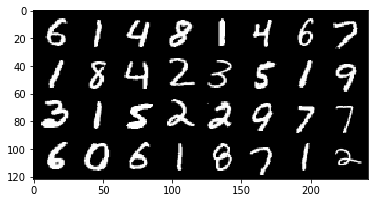

In [13]:
show_img("test real",X_real_samples[:32].cpu().view(32,1,28,28))

Embeddings


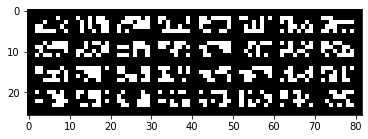

In [71]:
show_img("Embeddings",Z_samples[:32].detach().view(32,1,4,8).cpu())

## Visualizando o "espaço de features"

In [72]:
import umap

In [73]:
%%time
embedding_real = umap.UMAP(n_neighbors=25,min_dist=0.3,n_epochs=2000,
                      metric='euclidean').fit_transform(X_real)
embedding_fake = umap.UMAP(n_neighbors=25,min_dist=0.3,n_epochs=2000,
                      metric='euclidean').fit_transform(X_fake)

CPU times: user 22.1 s, sys: 3.3 s, total: 25.4 s
Wall time: 19.6 s


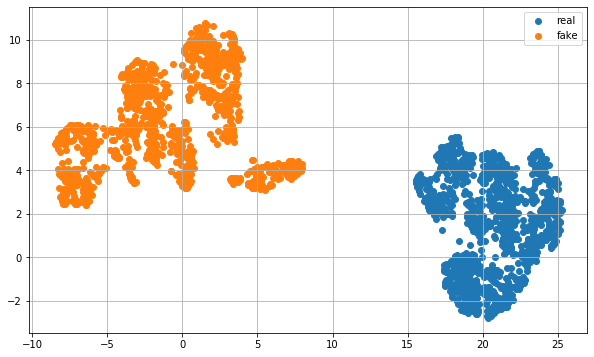

In [74]:
plt.figure(figsize=(10,6))
plt.scatter(x=embedding_real[:,0],y=embedding_real[:,1],label="real")
plt.scatter(x=embedding_fake[:,0],y=embedding_fake[:,1],label="fake")
plt.legend(loc=0)
plt.grid(True)
plt.show()

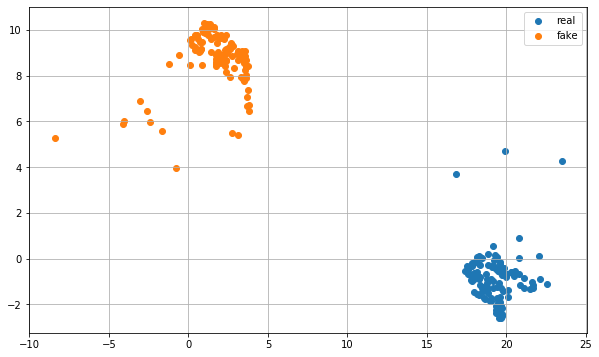

In [75]:
digit = 9
plt.figure(figsize=(10,6))
embedding_real_ = embedding_real[np.where(y_labels[:sample_size]==digit)]
embedding_fake_ = embedding_fake[np.where(y_labels[:sample_size]==digit)]
labels_ = [np.where(y_labels[:sample_size]==0)]
plt.scatter(x=embedding_real_[:,0],y=embedding_real_[:,1],label="real")
plt.scatter(x=embedding_fake_[:,0],y=embedding_fake_[:,1],label="fake")
plt.legend(loc=0)
plt.grid(True)
plt.show()

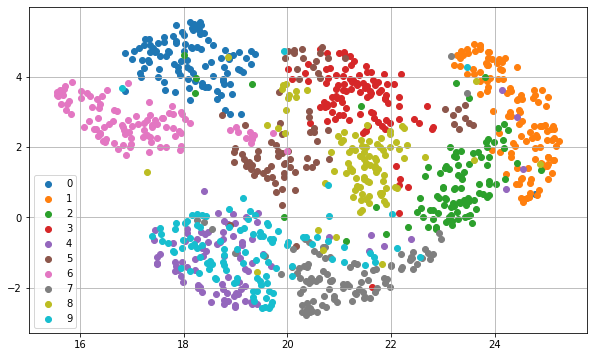

In [76]:
plt.figure(figsize=(10,6))
for i in range(10):
    embedding_real_ = embedding_real[np.where(y_labels[:sample_size]==i)]
    labels_ = [np.where(y_labels[:sample_size]==0)]
    plt.scatter(x=embedding_real_[:,0],y=embedding_real_[:,1],label=i)
plt.legend(loc=0)
plt.grid(True)
plt.show()

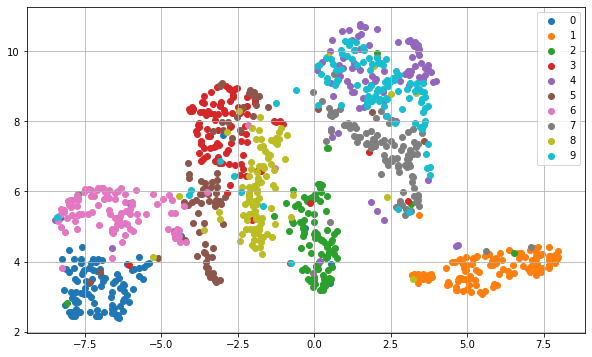

In [77]:
plt.figure(figsize=(10,6))
for i in range(10):
    embedding_fake_ = embedding_fake[np.where(y_labels[:sample_size]==i)]
    labels_ = [np.where(y_labels[:sample_size]==0)]
    plt.scatter(x=embedding_fake_[:,0],y=embedding_fake_[:,1],label=i)
plt.legend(loc=0)
plt.grid(True)
plt.show()

## Visualizando o "espaço latente"

In [78]:
%%time
embedding_Z = umap.UMAP(n_neighbors=25,min_dist=0.3,n_epochs=2000,
                      metric='euclidean').fit_transform(Z)

CPU times: user 9.81 s, sys: 1.36 s, total: 11.2 s
Wall time: 8.87 s


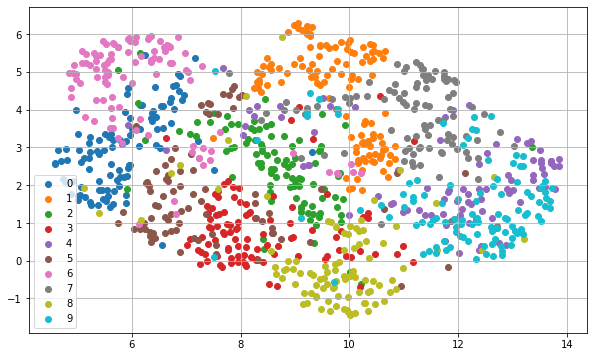

In [79]:
plt.figure(figsize=(10,6))
for i in range(10):
    embedding_Z_ = embedding_Z[np.where(y_labels[:sample_size]==i)]
    labels_ = [np.where(y_labels[:sample_size]==0)]
    plt.scatter(x=embedding_Z_[:,0],y=embedding_Z_[:,1],label=i)
plt.legend(loc=0)
plt.grid(True)
plt.show()